# Исследование надежности заемщиков.

Кредитный отдел банка хочет разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок для построения модели кредитного скоринга. Задача - проанализировать статистику о платёжеспособности клиентов и выяснить:
 - Есть ли зависимость между количеством детей и возвратом кредита в срок
 - Есть ли зависимость между семейным положением и возвратом кредита в срок
 - Есть ли зависимость между уровнем дохода и возвратом кредита в срок
 - Как разные цели кредита влияют на его возврат в срок

### Шаг 1. Обзор данных

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Из первого взгляда на данные можно сделать следующие выводы:
 - в двух столбцах пропущены значения (days_employed и total_income)
 - непонятно что такое dob_years (date of birth?)
 - нужно проверить соотвествие education_id и  family_id
 - дни занятости выражены в странном формате. Есть минусовые значения, очень большие и все они не целые
 - неизвестны единицы измерения total_income

### Шаг 2.1 Заполнение пропусков

In [2]:
df['total_income'].isna().sum()/df['total_income'].count() #считаем долю пропущенных значений в столбце total_income


0.11234561521368405

Пропущено 11% значений в столбце. Если бы стояла задача выяснить, влияет ли доход на погашение кредита в срок, заполнять пропуски какими-то значениями было бы нельзя, но в данном случае заполним пропуски медианным значением. Медиана в данном случае лучшее приближение, так как уровень доходов распределен неравномерно -- могут быть резко выделяющиеся значения. 

In [3]:
df['total_income'] = df['total_income'].fillna(df['total_income'].median()) #заменяем все пропуски на медианное значение
df['total_income'].isna().sum() #проверяем, что все пропущенные значения заменились


0

В столбце days_employed тоже есть пропущенные значения. Так как их ровно столько же, скольки и для столбца total_income, можно предположить, что этот блок данных пропал из таблицы вместе, в результате какой-либо ошибки. Прежде чем заполнять пропуски в days_employed, разберемся с форматом записи

### Шаг 2.2 Проверка данных на аномалии и исправления.

Проверим значения в столбце dob_years

In [4]:
df['dob_years'].value_counts().sort_index() 

0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
28    503
29    545
30    540
31    560
32    510
33    581
34    603
35    617
36    555
37    537
38    598
39    573
40    609
41    607
42    597
43    513
44    547
45    497
46    475
47    480
48    538
49    508
50    514
51    448
52    484
53    459
54    479
55    443
56    487
57    460
58    461
59    444
60    377
61    355
62    352
63    269
64    265
65    194
66    183
67    167
68     99
69     85
70     65
71     58
72     33
73      8
74      6
75      1
Name: dob_years, dtype: int64

У 101 человека указан возраст 0. Это, очевидно, ошибка, но пока неизвестно чем заменить нулевое значение. Пока посмотрим на столбец days_employed и затем попробуем проанализировать эти два столбца вместе, так как они связаны

In [5]:
df.loc[df['days_employed']<0,'days_employed'].count()

15906

Б**о**льшая часть значений в столбце со стажем отрицательная. К тому же, положительное значение в пятой строке -- 340266 дней, а это 932 года. Значит это не просто ошибка ввода, а какая-то другая логика данных

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

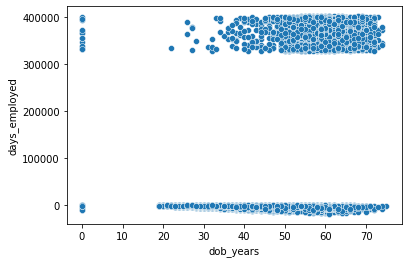

In [6]:
import seaborn as sns
sns.scatterplot(x=df['dob_years'], y= df['days_employed'])

На графике выделяется нижняя аномальная полоса значений ниже нуля. Замена их на модули аномалию не уберет. Можно предположить, что отрицательные значения появились случайно, поднять их на 350 000 и растянуть до ширины основной полосы

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

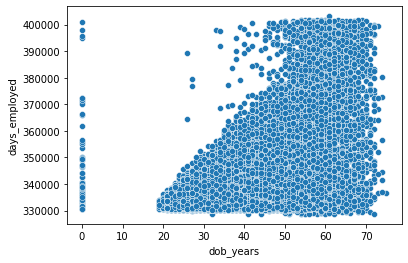

In [7]:
#расчет множителя для нормировки
multiplier = (df.loc[df['days_employed']<0, 'days_employed'].max()-df.loc[df['days_employed']<0, 'days_employed'].min())/(df.loc[df['days_employed']>0, 'days_employed'].max()-df.loc[df['days_employed']>0, 'days_employed'].min())


df.loc[df['days_employed']<0, 'days_employed'] *= -1/multiplier #переворот и растягивание аномальных значений
df.loc[df['days_employed']<100000, 'days_employed'] += 330000 #подъем аномальных значений вверх
sns.scatterplot(x=df['dob_years'], y= df['days_employed'])

Стало лучше, даже появилась заметная заивисимость стажа от возраста. Но значение цифр остается непонятным. Так как значения days_employed  в данной работе не используются, оставим попытки расшифровать их значения и заменим пропущенные значения на медиану. 

Строки таблицы с возрастом 0 в реальной работе, вероятно, следовало бы выкинуть (так как их меньше 1%), но в данной работе не будем делать с ними ничего, так как возраст заемщиков не используется. 

In [8]:
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median()) #заполним пропуски медианой
df['days_employed'].isna().sum() #проверяем, что пропусков не осталось


0

Проверим данные в столбце children

In [9]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

У 47 людей -1 ребенок. Будем считать, что минус случайный и уберем его. У 76 людей 20 детей. Будем считать, что это тоже ошибка и заменим на 2

In [10]:
df.loc[df['children'] == -1,'children'] = 1
df.loc[df['children'] == 20,'children'] = 2

df['children'].value_counts() #проверяем, что замена произошла успешно

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Проверяем значения в столбцах education_id и family_status_id

In [11]:
df['education_id'].value_counts()

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

In [12]:
df['family_status_id'].value_counts()


0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

В этих столбцах значения выглядят адекватно, соотвествуют количеству категорий образования и семейного положения (проверка этих столбцов -- ниже, в пункте 0.5).

Проверим значения столбца gender

In [13]:
df['gender'].value_counts()


F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Есть значение XNA, но вряд ли это ошибка. Исправлять не будем.

Проверим значения столбцов income_type и debt

In [14]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [15]:
df['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

Аномалий в этих столбцах не обнаружено

### Шаг 2.3. Изменение типов данных.

In [16]:
df['total_income'] = df['total_income'].astype('int') #замена типа значений total_income на целочисленный
df.info() #проверяем, что замена прошла успешно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


### Шаг 2.4. Удаление дубликатов.

Проверяем таблицу на наличие явных дубликатов

In [17]:
df.duplicated().sum() #подсчет дубликатов

54

In [18]:
df.loc[df.duplicated()].sort_values(by='dob_years')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
19321,0,338042.686782,23,среднее,1,Не женат / не замужем,4,F,сотрудник,0,145017,сделка с подержанным автомобилем
18328,0,338042.686782,29,высшее,0,женат / замужем,0,M,сотрудник,0,145017,покупка жилой недвижимости
21281,1,338042.686782,30,высшее,0,женат / замужем,0,F,сотрудник,0,145017,покупка коммерческой недвижимости
18349,1,338042.686782,30,высшее,0,женат / замужем,0,F,госслужащий,0,145017,покупка жилья для семьи
13878,1,338042.686782,31,среднее,1,женат / замужем,0,F,компаньон,0,145017,покупка жилья
16904,1,338042.686782,32,высшее,0,женат / замужем,0,F,сотрудник,0,145017,на покупку подержанного автомобиля
4182,1,338042.686782,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,145017,свадьба
9238,2,338042.686782,34,среднее,1,женат / замужем,0,F,сотрудник,0,145017,покупка жилья для сдачи
13773,0,338042.686782,35,среднее,1,гражданский брак,1,F,сотрудник,0,145017,сыграть свадьбу
14432,2,338042.686782,36,высшее,0,женат / замужем,0,F,госслужащий,0,145017,получение образования


Pandas насчитал 54 дубликата, но видно, что среди них всего несколько полных совпадений (например строки с индексами 21132 и 16176). Несмотря на это, удаляем все дубликаты в соотвествие с заданием

In [19]:
df = df.drop_duplicates().reset_index(drop=True) #удаление дубликатов с присваиванием новых индексов
df.duplicated().sum() #проверка, что удаление прошло успешно

0

Поверим данные в столбце education

In [20]:
df['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Есть много неявных дубликатов, которые возникли из-за записи в разных регистрах. Чтобы привести в порядок, приведем все к нижнему регистру

In [21]:
df['education']=df['education'].str.lower() #замена регистра
df['education'].value_counts() #проверка, что замена прошла успешно

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Поверим данные в столбце family_status

In [22]:
df['family_status'].value_counts()


женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Неявных дубликатов нет, но есть лишняя заглавная буква

In [23]:
df['family_status']=df['family_status'].str.lower()#замена регистра
df['family_status'].value_counts()#проверка, что замена прошла успешно

женат / замужем          12344
гражданский брак          4163
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

После удаления неявных дубликатов в столбцах могли появиться новые дубликаты

In [24]:
df.duplicated().sum() #подсчет дубликатов

17

In [25]:
df = df.drop_duplicates().reset_index(drop=True) #удаление дубликатов с присваиванием новых индексов
df.duplicated().sum() #проверка, что удаление прошло успешно

0

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [26]:
#Cоздание датафрейма, в котором каждому уникальному значению из education соответствует уникальное значение education_id
education_dict = df[['education', 'education_id']].drop_duplicates().reset_index(drop=True)

#Cоздание датафрейма, в котором каждому уникальному значению из family_status соответствует уникальное значение family_status_id
family_dict = df[['family_status', 'family_status_id']].drop_duplicates().reset_index(drop=True)


In [27]:
df = df.drop(columns=['education', 'family_status']) #удаление из исходной таблицы столбцов education и family_status

display(df.head())


,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,363551.956442,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,346004.417307,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,352361.239865,33,1,0,M,сотрудник,0,145885,покупка жилья
3,3,346401.837112,32,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу


### Шаг 2.6. Категоризация дохода.

In [28]:
#функция для присваивания категории доходов
def income_category(income): 
    if income <= 30000:
        return 'E'
    if 30001 <= income <= 50000:
        return 'D'
    if 50001 <= income <= 200000:
        return 'C'
    if 200001 <= income <= 1000000:
        return 'B'
    if income >= 1000001:
        return 'A'
    
df['total_income_category'] = df['total_income'].apply(income_category) #создание нового столбца с указанием категории доходов
display(df.head())

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,363551.956442,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,346004.417307,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,352361.239865,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,346401.837112,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Шаг 2.7. Категоризация целей кредита.

Посмотрим на значения столбца purpose

In [29]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Много неявных дубликатов. Преобразуем их в новый столбец с ограниченным числом категорий

In [30]:
#функция для присваивания категории 
def purpose_category(purpose):
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    elif ('автомобил' in purpose):
        return 'операции с автомобилем'
    elif ('жиль' in purpose)|('недвижимост' in purpose):
        return 'операции с недвижимостью'
    elif 'образовани' in purpose:
        return 'получение образования'
    else:
        return 'ошибка'
df['purpose_category'] = df['purpose'].apply(purpose_category)#создание нового столбца с указанием категории
display(df['purpose_category'].value_counts())

операции с недвижимостью    10811
операции с автомобилем       4306
получение образования        4013
проведение свадьбы           2324
Name: purpose_category, dtype: int64

### Ответы на вопросы.

##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [31]:
#подсчет числа долгов и общего числа кредитов, сгруппированных по количеству детей
grouped_by_children = df.groupby('children').agg({'debt': ['count', 'sum']}) 
#подсчет доли должников 
grouped_by_children['rate'] = grouped_by_children['debt']['sum']/grouped_by_children['debt']['count']
display(grouped_by_children)

debt            rate
          count   sum          
children                       
0         14091  1063  0.075438
1          4855   445  0.091658
2          2128   202  0.094925
3           330    27  0.081818
4            41     4  0.097561
5             9     0  0.000000

##### Вывод 1:

Связь между возвратом кредита в срок и количеством детей наблюдается, хотя и не очень значительная. 

Разница в доле должников среди бездетных и имеющих детей составляет 1,5-2%. Количество детей практически не влияет на надежность заемщика (разница составляет десятые процента). 

Наблюдается небольшой "провал" у людей, имеющих 3 ребенка, но это вряд ли говорит о какой-либо закономерности. Скорее всего, это объясняется тем, что таких заемщиков на порядок меньше, чем заемщиков с 2 или 1 ребенком. По той же причине нулевой процент должников среди заемщиков с 5 детьми не позволяет говорить об абсолютной надежности таких клиентов. 

##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [32]:
#подсчет числа долгов и общего числа кредитов, сгруппированных по семейному положению
grouped_by_family = df.groupby('family_status_id').agg({'debt': ['count', 'sum']}) 
#подсчет доли должников 
grouped_by_family['rate'] = grouped_by_family['debt']['sum']/grouped_by_family['debt']['count']
display(grouped_by_family)

debt           rate
                  count  sum          
family_status_id                      
0                 12339  931  0.075452
1                  4151  388  0.093471
2                   959   63  0.065693
3                  1195   85  0.071130
4                  2810  274  0.097509

##### Вывод 2:

Наблюдается зависимость между семейным положением и возвратом кредита в срок. Самыми надежными оказались вдовцы/вдовы (6,6% должников). Самыми ненадежными -- состоящие "в гражданском браке" и холостяки. Причем среди последних доля должников составляет почти 10% 

##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [33]:
#подсчет числа долгов и общего числа кредитов, сгруппированных по уровню дохода
grouped_by_income = df.groupby('total_income_category').agg({'debt': ['count', 'sum']}) 

#подсчет доли должников 
grouped_by_income['rate'] = grouped_by_income['debt']['sum']/grouped_by_income['debt']['count']
display(grouped_by_income)

debt            rate
                       count   sum          
total_income_category                       
A                         25     2  0.080000
B                       5041   356  0.070621
C                      16016  1360  0.084915
D                        350    21  0.060000
E                         22     2  0.090909

##### Вывод 3:

Наблюдается зависимость между уровнем дохода и возвратом кредита в срок. Самыми надежными заемщиками оказываются люди с доходами "ниже среднего" -- D (6% должников). Самыми ненадежными -- люди с самым низким доходом и со средним доходом. 

Однако делать строгие выводы нельзя, так как количество заемщиков с разной категорией дохода отличается на несколько порядков. 

##### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

In [34]:
#подсчет числа долгов и общего числа кредитов, сгруппированных по назначению кредита
grouped_by_purpose = df.groupby('purpose_category').agg({'debt': ['count', 'sum']}) 

#подсчет доли должников 
grouped_by_purpose['rate'] = grouped_by_purpose['debt']['sum']/grouped_by_purpose['debt']['count']
display(grouped_by_purpose)

debt           rate
                          count  sum          
purpose_category                              
операции с автомобилем     4306  403  0.093590
операции с недвижимостью  10811  782  0.072334
получение образования      4013  370  0.092200
проведение свадьбы         2324  186  0.080034

##### Вывод 4:

Цель кредита влияет на его возврат в срок (разброс доли должников в зависимости от цели -- 2,1%). Чаще всего кредит закрывают в срок те, кто взял его для операций с недвижимостью. Самая "ненадежная" цель — операции с автомобилем и получение образования (более 9% должников)

## Общий вывод:

- семейное положение и количество детей у клиента оказывают небольшое влияние на возврат кредита в срок

- наличие хотя бы одного ребенка важнее, чем количество детей
 
- уровень дохода потенциально может влияет на надежность заемщика. Для изучения этого вопроса необходимо собрать больше данных

- цель кредита влияет на возврат кредита в срок в той же степени, что семейное положение и наличие детей